# Análisis de Redes Sociales, Práctica I
Paula Corral rebollar y Lucía Cuevas Serrano

# Datos

## Cargar datos

Cargamos los datos directamente del archivo en github y lo abrimos como un grafo usando NetworkX.

In [1]:
import requests
import networkx as nx
from io import BytesIO
import numpy as np

# Descargar archivo
response = requests.get("https://raw.githubusercontent.com/luciacuevascsv/analisis_redes_sociales/main/Practica%20I/hashtags_cleaned.graphml")
response.raise_for_status()

# Cargar grafo
file_like = BytesIO(response.content)
G = nx.read_graphml(file_like)
print("Número de nodos:", G.number_of_nodes())
print("Número de aristas:", G.number_of_edges())


Número de nodos: 47544
Número de aristas: 536124


## Visualizar datos

Seguimos los resultados mostrados en [Campaign 2020 on Twitter: Top Names and Hashtags by Mention Volume de The George Washington University](https://gspm.gwu.edu/sites/g/files/zaxdzs5061/files/downloads/Campaign%202020%20on%20Twitter.pdf) mostrados a continuación para ver subgrafos basados en hashtags populares de ambos partidos (Republicano en la primera fila y Demócrata en la segunda).

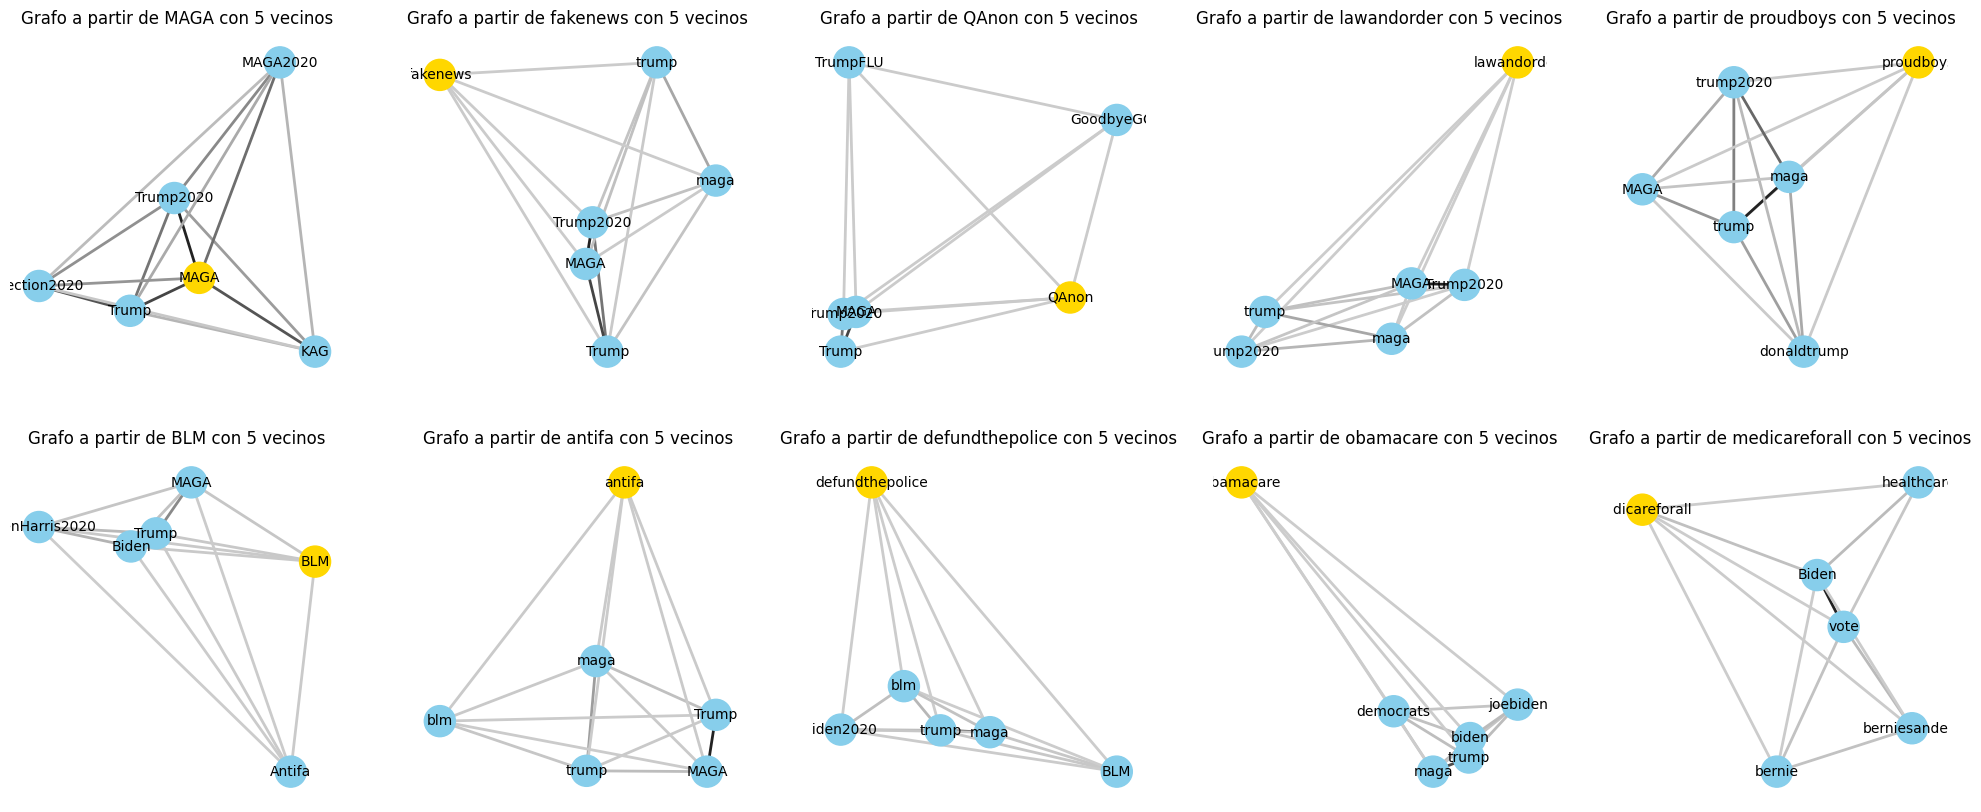

In [22]:
import matplotlib.pyplot as plt

def demo_nodos(central_node, number_neighbors):

    # Ordenar vecinos
    neighbors = list(G[central_node].items())
    neighbors_sorted = sorted(neighbors, key=lambda x: float(x[1].get("weight",0)), reverse=True)
    top5_neighbors = [n for n, attr in neighbors_sorted[:number_neighbors]]

    # Crear subgrafo
    sub_nodes = [central_node] + top5_neighbors
    subG = G.subgraph(sub_nodes)

    # Dibujar nodos
    pos = nx.spring_layout(subG, seed=42)
    node_colors = ["gold" if n == central_node else "skyblue" for n in subG.nodes()]
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=500)

    # Colores de las aristas
    min_gray = "#cccccc"  
    max_gray = "#222222"  
    def hex_to_rgb(h):
        h = h.lstrip("#")
        return tuple(int(h[i:i+2],16)/255 for i in (0,2,4))

    rgb_min = hex_to_rgb(min_gray)
    rgb_max = hex_to_rgb(max_gray)

    weights = [float(subG[u][v].get("weight",1)) for u,v in subG.edges()]
    max_weight = max(weights)

    edge_colors = []
    for w in weights:
        t = w / max_weight  
        r = rgb_min[0] + t*(rgb_max[0]-rgb_min[0])
        g = rgb_min[1] + t*(rgb_max[1]-rgb_min[1])
        b = rgb_min[2] + t*(rgb_max[2]-rgb_min[2])
        edge_colors.append((r,g,b))

    # Dibujar aristas
    nx.draw_networkx_edges(subG, pos, width=2, edge_color=edge_colors)

    # Etiquetas
    nx.draw_networkx_labels(subG, pos, font_size=10)

    plt.title(f"Grafo a partir de {central_node} con {number_neighbors} vecinos")
    plt.axis('off')

hashtags = [
    "MAGA", "fakenews", "QAnon", "lawandorder", "proudboys",
    "BLM", "antifa", "defundthepolice", "obamacare", "medicareforall"
]

fig, axes = plt.subplots(2,5, figsize=(25,10))  

for ax, hashtag in zip(axes.flatten(), hashtags):
    plt.sca(ax) 
    demo_nodos(hashtag, 5)  


# Ejercicios

## 1. Calcula las comunidades utilizando el algoritmo de Leiden. ¿Cuántas comunidades salen? 

In [3]:
!pip install cdlib --quiet
!pip install leidenalg --quiet

In [4]:
from cdlib.algorithms import leiden

num_communities=1000
num_iteraciones=0
lowest_num_communities=1000

while num_communities>45 and num_iteraciones<=10: # Restrinjo el número de nodos para que no haya mucho ruido de comunidades con pocos nodos (y no filtrarlos después)
    communities = leiden(G)
    num_communities = len(communities.communities)
    if num_communities<lowest_num_communities:
        lowest_num_communities=num_communities
        communities_save=communities
    num_iteraciones+=1
    print(f"Iteración {num_iteraciones}: {num_communities} comunidades.\n")

if num_iteraciones==10:
    communities=communities_save

print("Número de comunidades detectadas:", num_communities)


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap'}
Iteración 1: 37 comunidades.

Número de comunidades detectadas: 37


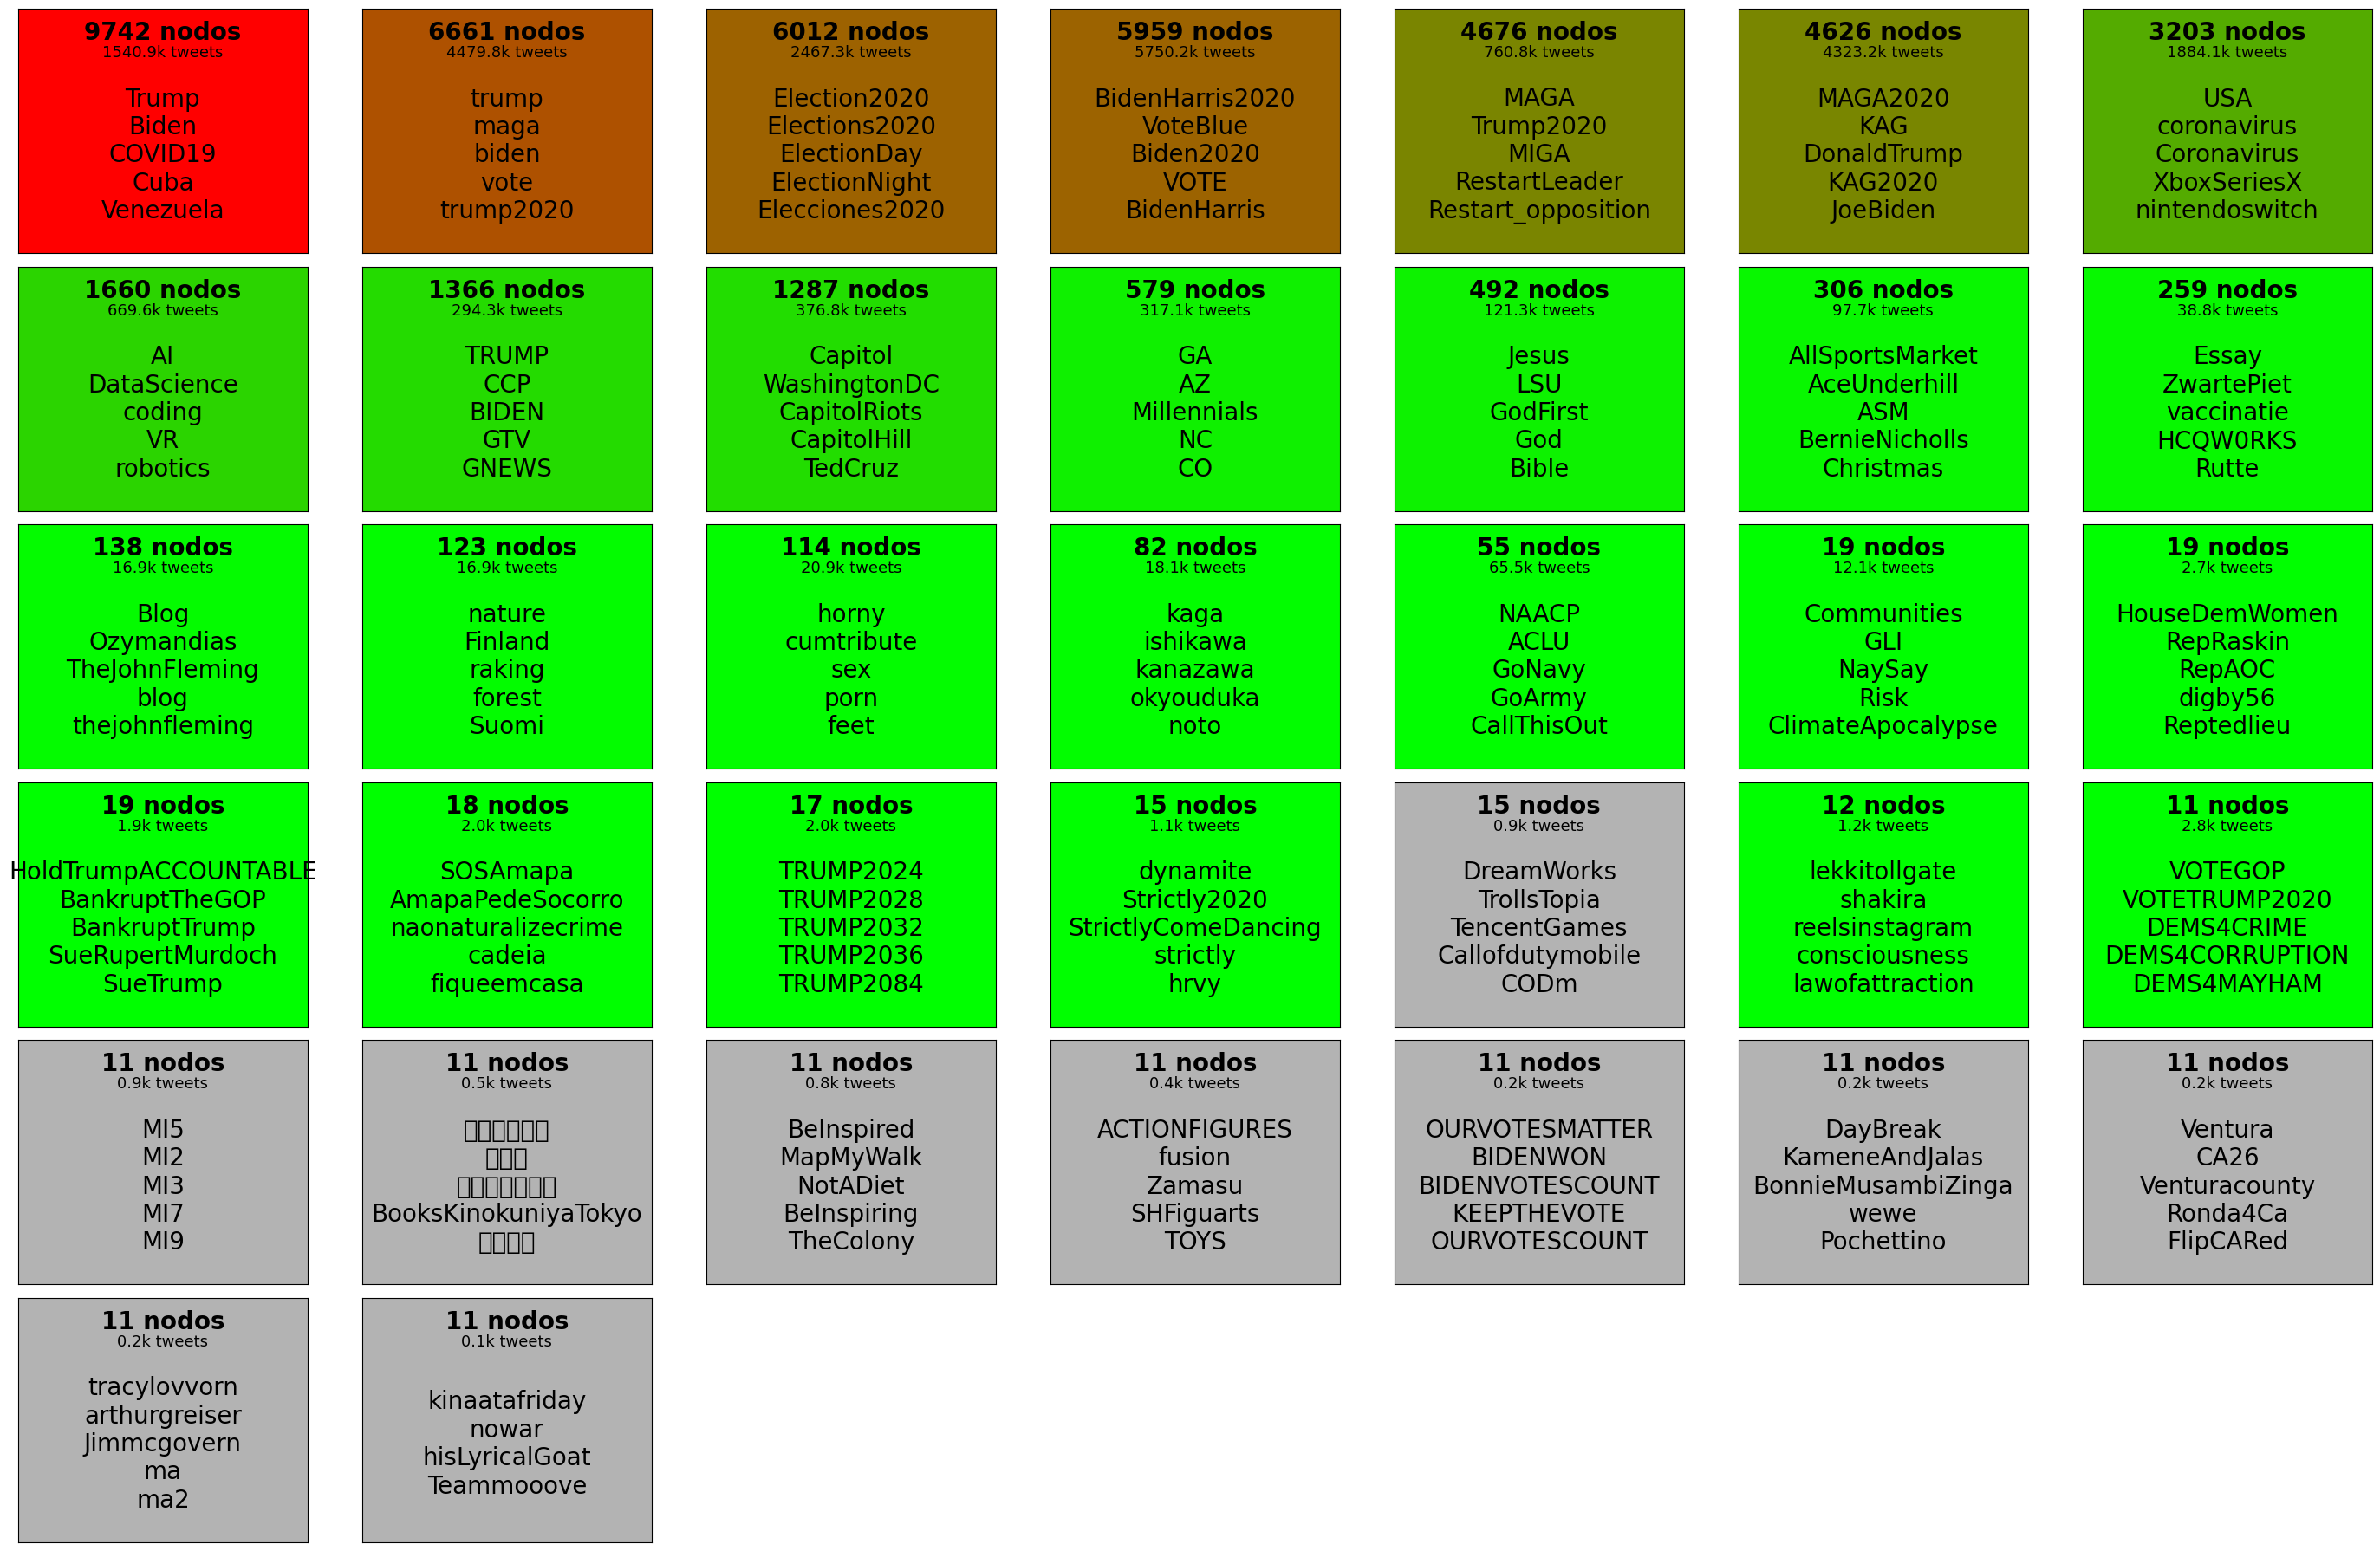

In [5]:
# Calcular nodos más importantes (mayor weight total) de cada comunidad
community_sizes = [len(com) for com in communities.communities]
top_nodes = []
community_tweets = []  

for com in communities.communities:
    subG = G.subgraph(com)
    node_weights = {n: sum(float(subG[n][nbr].get("weight",1)) for nbr in subG[n]) for n in subG.nodes()}
    top5 = sorted(node_weights, key=node_weights.get, reverse=True)[:5]
    top_nodes.append(top5)

    total_tweets = sum(node_weights.values())
    community_tweets.append(total_tweets)

def plot_comunidades(communities, top_nodes, community_sizes, community_tweets, minimum_tweets_filter=0, minimum_tweets_color=0):

    filtered_indices = [i for i, t in enumerate(community_tweets) if t >= minimum_tweets_filter]

    cols = 7
    rows = int(np.ceil(len(filtered_indices) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    
    if rows == 1:
        axes = np.array([axes])

    min_size, max_size = min([community_sizes[i] for i in filtered_indices]), max([community_sizes[i] for i in filtered_indices])

    for plot_idx, i in enumerate(filtered_indices):
        row_idx = plot_idx // cols
        col_idx = plot_idx % cols
        ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]

        # Color según tamaño de la comunidad
        if community_tweets[i] < minimum_tweets_color:
            color = (0.7, 0.7, 0.7) 
        else:
            size = community_sizes[i]
            t = (size - min_size) / (max_size - min_size + 1e-6)
            color = (t, 1-t, 0)  
        
        ax.add_patch(plt.Rectangle((0,0),1,1,color=color))

        # Escribir top 5 nodos
        text = "\n".join(top_nodes[i])
        ax.text(0.5, 0.4, text, ha="center", va="center", fontsize=20)
        ax.text(0.5, 0.95, f"{size} nodos", ha="center", va="top", fontsize=20, fontweight='bold')

        total_tweets_k = community_tweets[i] / 1000
        ax.text(0.5, 0.85, f"{total_tweets_k:.1f}k tweets", ha="center", va="top", fontsize=13)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)

    total_slots = rows * cols
    for j in range(len(filtered_indices), total_slots):
        row_idx = j // cols
        col_idx = j % cols
        ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_comunidades(communities, top_nodes, community_sizes, community_tweets, 0, 1000)

## 2. Utiliza Weisfeiler-lehmangraph kernels para codificar cada una de las comunidades como si de grafos independientes se trataran. Basado en los resultados obtenidos, ¿qué comunidades son más similares? 


In [ ]:
'''!pip install grakel --quiet
!pip uninstall -y numpy --quiet
!pip install numpy==1.26.4 --quiet'''

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


### Usando todos los nodos

In [6]:
from grakel.utils import graph_from_networkx
from grakel.kernels import WeisfeilerLehman, VertexHistogram

# Filtrar comunidades con más de X tweets
min_tweets = 0
indices = [i for i, t in enumerate(community_tweets) if t > min_tweets]

# Subgrafos filtrados
subgraphs = [G.subgraph(communities.communities[i]).copy() for i in indices]

# Convertir cada comunidad en un grafo independiente
grakel_graphs = graph_from_networkx(subgraphs, val_node_labels='0')

# Crear el kernel WL
wl = WeisfeilerLehman(n_iter=3, normalize=True, base_graph_kernel=VertexHistogram)
K = wl.fit_transform(grakel_graphs)

# Eliminar diagonal y triangulo inferior
K_no_diag = K.copy()
np.fill_diagonal(K_no_diag, 0)
K_unique = K_no_diag.copy()
K_unique[np.tril_indices_from(K_unique)] = 0

# Obtener los índices de las mayores similitudes
flat_indices = np.argsort(K_unique, axis=None)[-10:]
pairs = np.unravel_index(flat_indices, K_unique.shape)

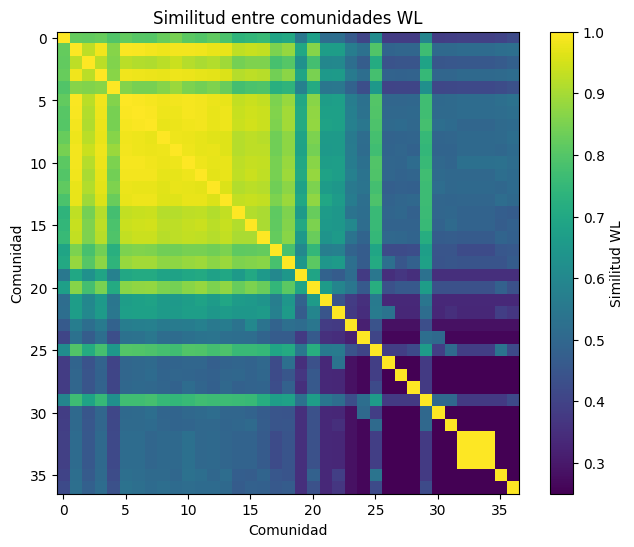

In [7]:
indices = np.unravel_index(
    np.argsort(K_no_diag, axis=None)[-3:],
    K_no_diag.shape
)

similarities = K_no_diag[indices]

# Heatmap de similitud
plt.figure(figsize=(8, 6))
plt.imshow(K, cmap="viridis")
plt.colorbar(label="Similitud WL")
plt.title("Similitud entre comunidades WL")
plt.xlabel("Comunidad")
plt.ylabel("Comunidad")
plt.show()

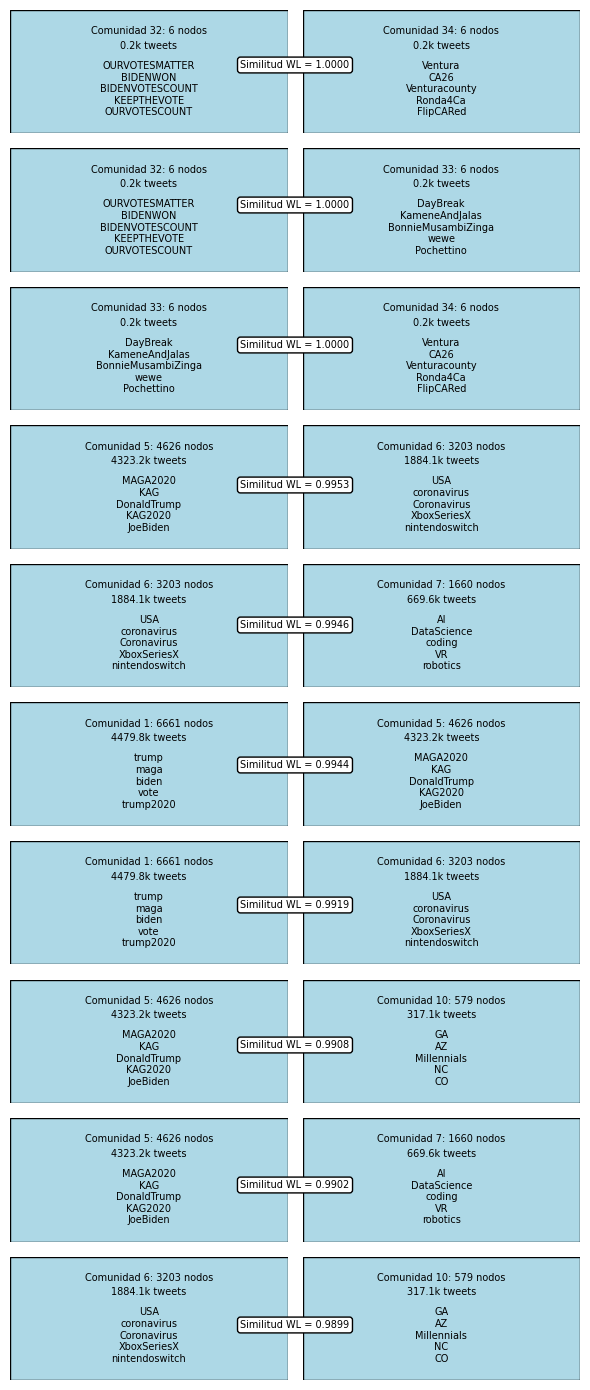

In [8]:
from matplotlib.patches import Rectangle

def plot_comunidades_similitudes(community_sizes, community_tweets, top_nodes, K_unique, num_pairs=10, min_size=50, korm="k"):    
    pairs_i, pairs_j = np.triu_indices_from(K_unique, k=1)

    mask = (np.array(community_sizes)[pairs_i] >= min_size) & (np.array(community_sizes)[pairs_j] >= min_size)
    filtered_i = pairs_i[mask]
    filtered_j = pairs_j[mask]
        
    sims = K_unique[filtered_i, filtered_j]
    
    sorted_idx = np.argsort(sims)[::-1]
    filtered_i = filtered_i[sorted_idx]
    filtered_j = filtered_j[sorted_idx]
    sims = sims[sorted_idx]
    
    n_plot = min(num_pairs, len(filtered_i))
    
    fig, axes = plt.subplots(nrows=n_plot, ncols=2, figsize=(6, n_plot * 1.4))
    if n_plot == 1:
        axes = axes.reshape(1, 2)
    
    for row in range(n_plot):
        i, j = filtered_i[row], filtered_j[row]
        sim = sims[row]
        
        for col, com_idx in enumerate([i, j]):
            ax = axes[row, col]
            ax.axis("off")
            
            ax.add_patch(
                Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                          facecolor="lightblue", edgecolor="black", linewidth=1, zorder=0))
            
            size = community_sizes[com_idx]
            nodes = top_nodes[com_idx]
            text = f"Comunidad {com_idx}: {size} nodos\n\n\n" + "\n".join(nodes)
            ax.text(0.5, 0.5, text, ha="center", va="center", fontsize=7, family="DejaVu Sans", zorder=1)
            if korm == "m":
                ax.text(0.5, 0.75, f"{community_tweets[com_idx]/1_000_000:.1f}M tweets", 
                        ha="center", va="top", fontsize=7)
            elif korm == "k":
                ax.text(0.5, 0.75, f"{community_tweets[com_idx]/1_000:.1f}k tweets", 
                        ha="center", va="top", fontsize=7)

        
        fig.text(0.5, 1 - (row + 0.5) / n_plot, f"Similitud WL = {sim:.4f}",
                 ha="center", va="center", fontsize=7,
                 bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))
    
    plt.tight_layout()
    plt.show()

plot_comunidades_similitudes(community_sizes, community_tweets, top_nodes, K_unique, 10, 0, "k")

### Filtrando por número de tweets

In [9]:
# Filtrar comunidades con más de 1000 tweets
min_tweets = 1000
filtered_indices = [i for i, t in enumerate(community_tweets) if t > min_tweets]

# Subgrafos filtrados
filtered_subgraphs = [G.subgraph(communities.communities[i]).copy() for i in filtered_indices]

# Convertir cada comunidad en un grafo independiente
filtered_grakel_graphs = graph_from_networkx(filtered_subgraphs, val_node_labels='0')

# Crear el kernel WL
wl = WeisfeilerLehman(n_iter=3, normalize=True, base_graph_kernel=VertexHistogram)
filtered_K = wl.fit_transform(filtered_grakel_graphs)

# Eliminar diagonal y triangulo inferior
filtered_K_no_diag = filtered_K.copy()
np.fill_diagonal(filtered_K_no_diag, 0)
filtered_K_unique = filtered_K_no_diag.copy()
filtered_K_unique[np.tril_indices_from(filtered_K_unique)] = 0

# Obtener los índices de las mayores similitudes
filtered_flat_indices = np.argsort(filtered_K_unique, axis=None)[-10:]
filtered_pairs = np.unravel_index(filtered_flat_indices, filtered_K_unique.shape)

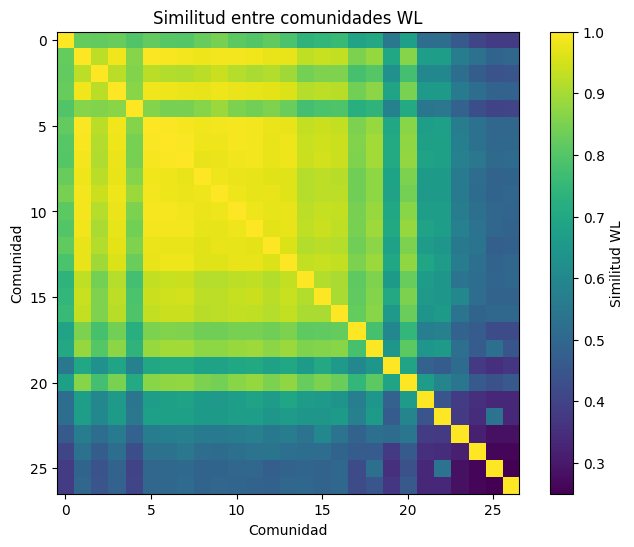

In [10]:
filtered_indices = np.unravel_index(
    np.argsort(filtered_K_no_diag, axis=None)[-3:],
    filtered_K_no_diag.shape
)

filtered_similarities = filtered_K_no_diag[filtered_indices]

# Heatmap de similitud
plt.figure(figsize=(8, 6))
plt.imshow(filtered_K, cmap="viridis")
plt.colorbar(label="Similitud WL")
plt.title("Similitud entre comunidades WL")
plt.xlabel("Comunidad")
plt.ylabel("Comunidad")
plt.show()

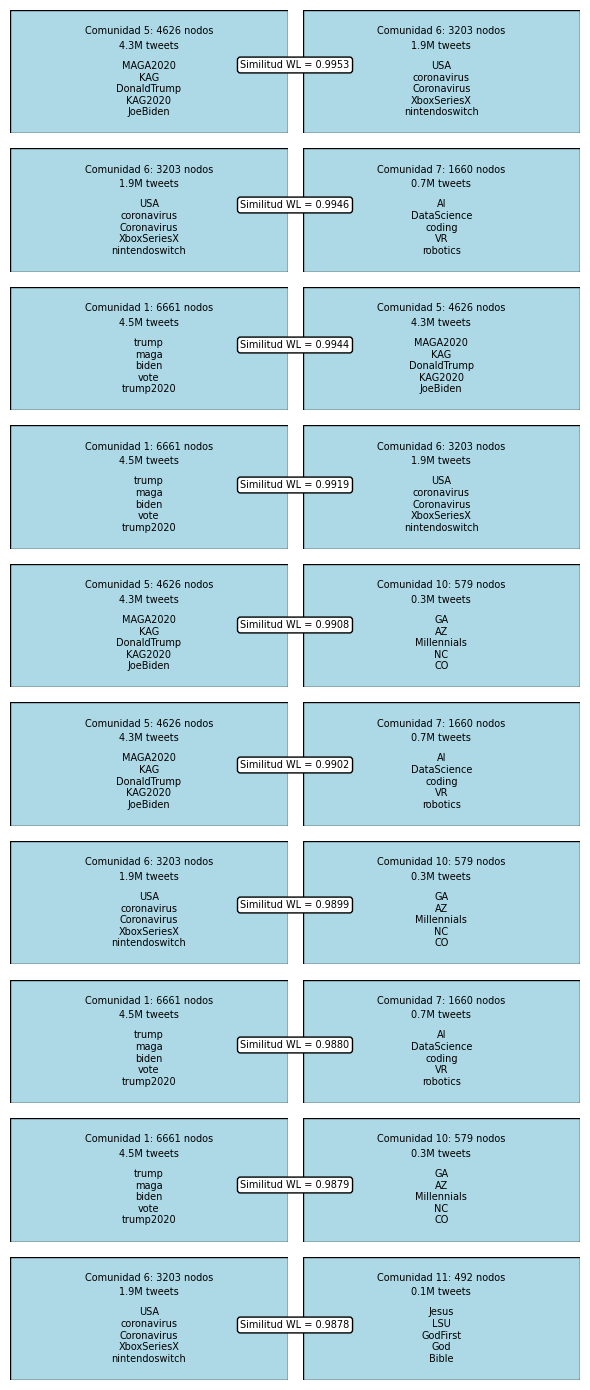

In [11]:
plot_comunidades_similitudes(community_sizes, community_tweets, top_nodes, filtered_K_unique, 10, 0, "m")

## 3. El tamaño del grafo excede el tiempo que tenemos en la práctica, por ello, y para tener una representación más compacta, colapsa el grafo de forma que cada nodo sea una comunidad, manteniendo los atributos. 


In [ ]:
community_map = {}
for cid, com in enumerate(communities.communities):
    for node in com:
        community_map[node] = cid

nx.set_node_attributes(G, community_map, "community")

def calculate_intercommunity_weight(G, nodes_1, nodes_2):
    weight = 0
    for u in nodes_1:
        for v in nodes_2:
            if G.has_edge(u, v):
                weight += float(G[u][v].get("weight", 1))
    return weight

G_coms = nx.quotient_graph(
    G,
    partition=lambda x, y: G.nodes[x]["community"] == G.nodes[y]["community"],
    node_data=lambda nodes: {
        "community": G.nodes[list(nodes)[0]]["community"],
        "size": len(nodes),
        "tweets": sum(
            sum(float(G[n][nbr].get("weight", 1)) for nbr in G[n])
            for n in nodes
        )
    },
    edge_data=lambda nodes1, nodes2: {
        "weight": calculate_intercommunity_weight(G, nodes1, nodes2)
    },
    relabel=True
)

weights = [G_coms.edges[e]["weight"] for e in G_coms.edges]
min_w, max_w = min(weights), max(weights)

for e in G_coms.edges:
    G_coms.edges[e]["weight"] = (G_coms.edges[e]["weight"] - min_w) / (max_w - min_w + 1e-6)


In [13]:
print("Nodos originales:", G.number_of_nodes())
print("Nodos colapsados:", G_coms.number_of_nodes())

Nodos originales: 47544
Nodos colapsados: 37


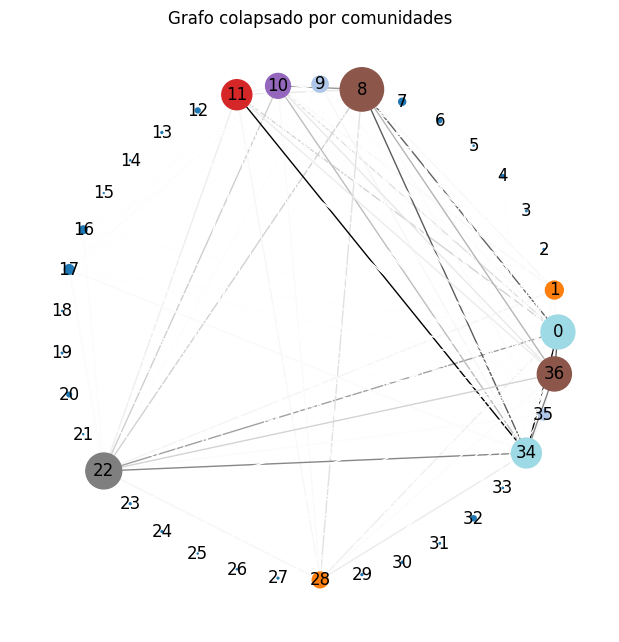

In [19]:
plt.figure(figsize=(6, 6))

nx.draw_kamada_kawai(
    G_coms,
    with_labels=True,
    node_size=[G_coms.nodes[n]["size"]/10 for n in G_coms.nodes],
    node_color=[G_coms.nodes[n]["tweets"] for n in G_coms.nodes],
    edge_color=[G_coms.edges[e]["weight"] for e in G_coms.edges],
    cmap=plt.cm.tab20,
    edge_cmap=plt.cm.Greys
)

plt.title("Grafo colapsado por comunidades")
plt.show()


## 4. Aplica distintas métricas que puedan resultar útiles para tener una mejor idea de las comunidades, y crea visualizaciones diferentes en función de las métricas. 

### Modularidad

In [29]:
# Preparar formato de comunidades

from networkx.algorithms.community import modularity

# Lista de sets de nodos
community_sets = [set(com) for com in communities.communities]
for u, v, data in G.edges(data=True):
    data["weight"] = float(data.get("weight", 1))

# Calcular modularidad ponderada

Q = modularity(
    G,
    community_sets,
    weight="weight"
)

print("Modularidad:", Q)


Modularidad: 0.3452571475444144


### Tamaño de las comunidades

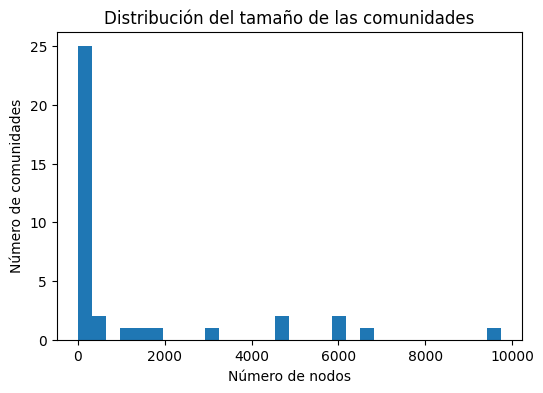

In [30]:
community_sizes = [len(com) for com in communities.communities]

plt.figure(figsize=(6,4))
plt.hist(community_sizes, bins=30)
plt.xlabel("Número de nodos")
plt.ylabel("Número de comunidades")
plt.title("Distribución del tamaño de las comunidades")
plt.show()


### Peso/tweets por comunidad

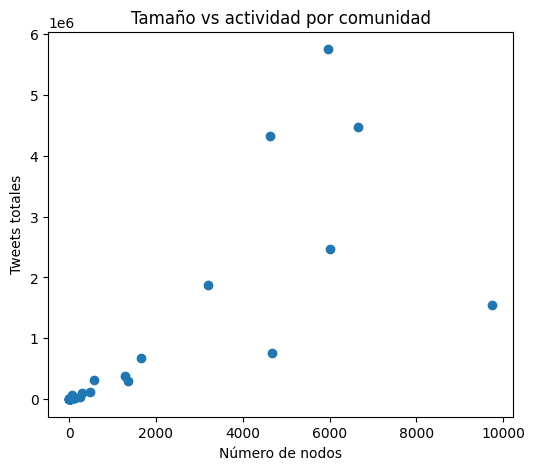

In [31]:
plt.figure(figsize=(6,5))
plt.scatter(community_sizes, community_tweets)
plt.xlabel("Número de nodos")
plt.ylabel("Tweets totales")
plt.title("Tamaño vs actividad por comunidad")
plt.show()


## 5. ¿Hay nodos centrales?, ¿qué métricas nos ayudan a saberlo? ¿Qué métricas macro nos servirían para explicar la estructura de la red, teniendo en cuenta que son comunidades y no nodos? 


## 6. ¿Merece la pena hacer comunidades solapadas o no solapadas?

## 7. ¿Si visualizamos la/s comunidad/es más grandes y las más pequeñas; que se ve, que nos dice esa representación? 

## 8. Describe los contenidos de cada comunidad. ¿Es posible, aunque sea intuitivamente, caracterizar una comunidad en función de sus hashtags más importantes? 


## 9. Finalmente, utilizando técnicas de predicción de aristas, ¿qué comunidades tienen más probabilidades de estar unidas? Habiendo descrito dichas comunidades previamente, ¿tienen sentido estas predicciones? 
